## Infos

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
	print('Not connected to a GPU')
else:
	print(gpu_info)

Fri Nov  1 19:13:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...    Off |   00000000:01:00.0  On |                  N/A |
| 34%   35C    P8             16W /  175W |     572MiB /   8192MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 16.6 gigabytes of available RAM

Not using a high-RAM runtime


## Setup

In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

/home/gui/.conda/envs/tcc_ctm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

numpy       : 2.1.2
pandas      : 2.2.3
torch       : 2.5.1
transformers: 4.46.1



In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/gui/.conda/envs/tcc_ctm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

## Data Exploration

In [2]:
class_names = ['negative', 'neutral', 'positive']

In [3]:
df = pd.read_csv('/home/gui/CTM_implementatio/fine_tunning_processor/sentiment_analysis/data/SentPt_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191371 entries, 0 to 191370
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Sentence  191370 non-null  object 
 1   V         191371 non-null  float64
 2   Label     191371 non-null  float64
dtypes: float64(2), object(1)
memory usage: 4.4+ MB


## Preprocessing 

In [4]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

In [5]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [6]:
sample_txt = 'Testando tokenizador do BERT'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')


 Sentence: Testando tokenizador do BERT
   Tokens: ['Tes', '##tando', 'to', '##ken', '##izador', 'do', 'B', '##ER', '##T']
Token IDs: [13167, 1552, 374, 8110, 16184, 171, 241, 5054, 22321]


In [7]:

encoding = tokenizer.encode_plus(
									sample_txt,
									max_length=32,
									add_special_tokens=True, 
									return_token_type_ids=False,
									pad_to_max_length=True,
									return_attention_mask=True,
									return_tensors='pt', 
								)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/gui/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [8]:
df.head()

,Sentence,V,Label
0,desfalecida,0.00,0.0
1,Se o cartel conseguir chantagear as autoridad...,0.51,1.0
2,Meu pai me levou para ver esse filme quando fo...,0.00,2.0
3,Um filme incomum para um público fora dos EUA....,0.00,2.0
4,não for levado a sério não ser levado a sério,0.00,0.0


In [9]:

df = df.dropna(subset=["Sentence"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191370 entries, 0 to 191370
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Sentence  191370 non-null  object 
 1   V         191370 non-null  float64
 2   Label     191370 non-null  float64
dtypes: float64(2), object(1)
memory usage: 5.8+ MB


In [11]:
token_lens = []

for txt in df.Sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Ploting token_len distribution

/tmp/ipykernel_53246/3566661759.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


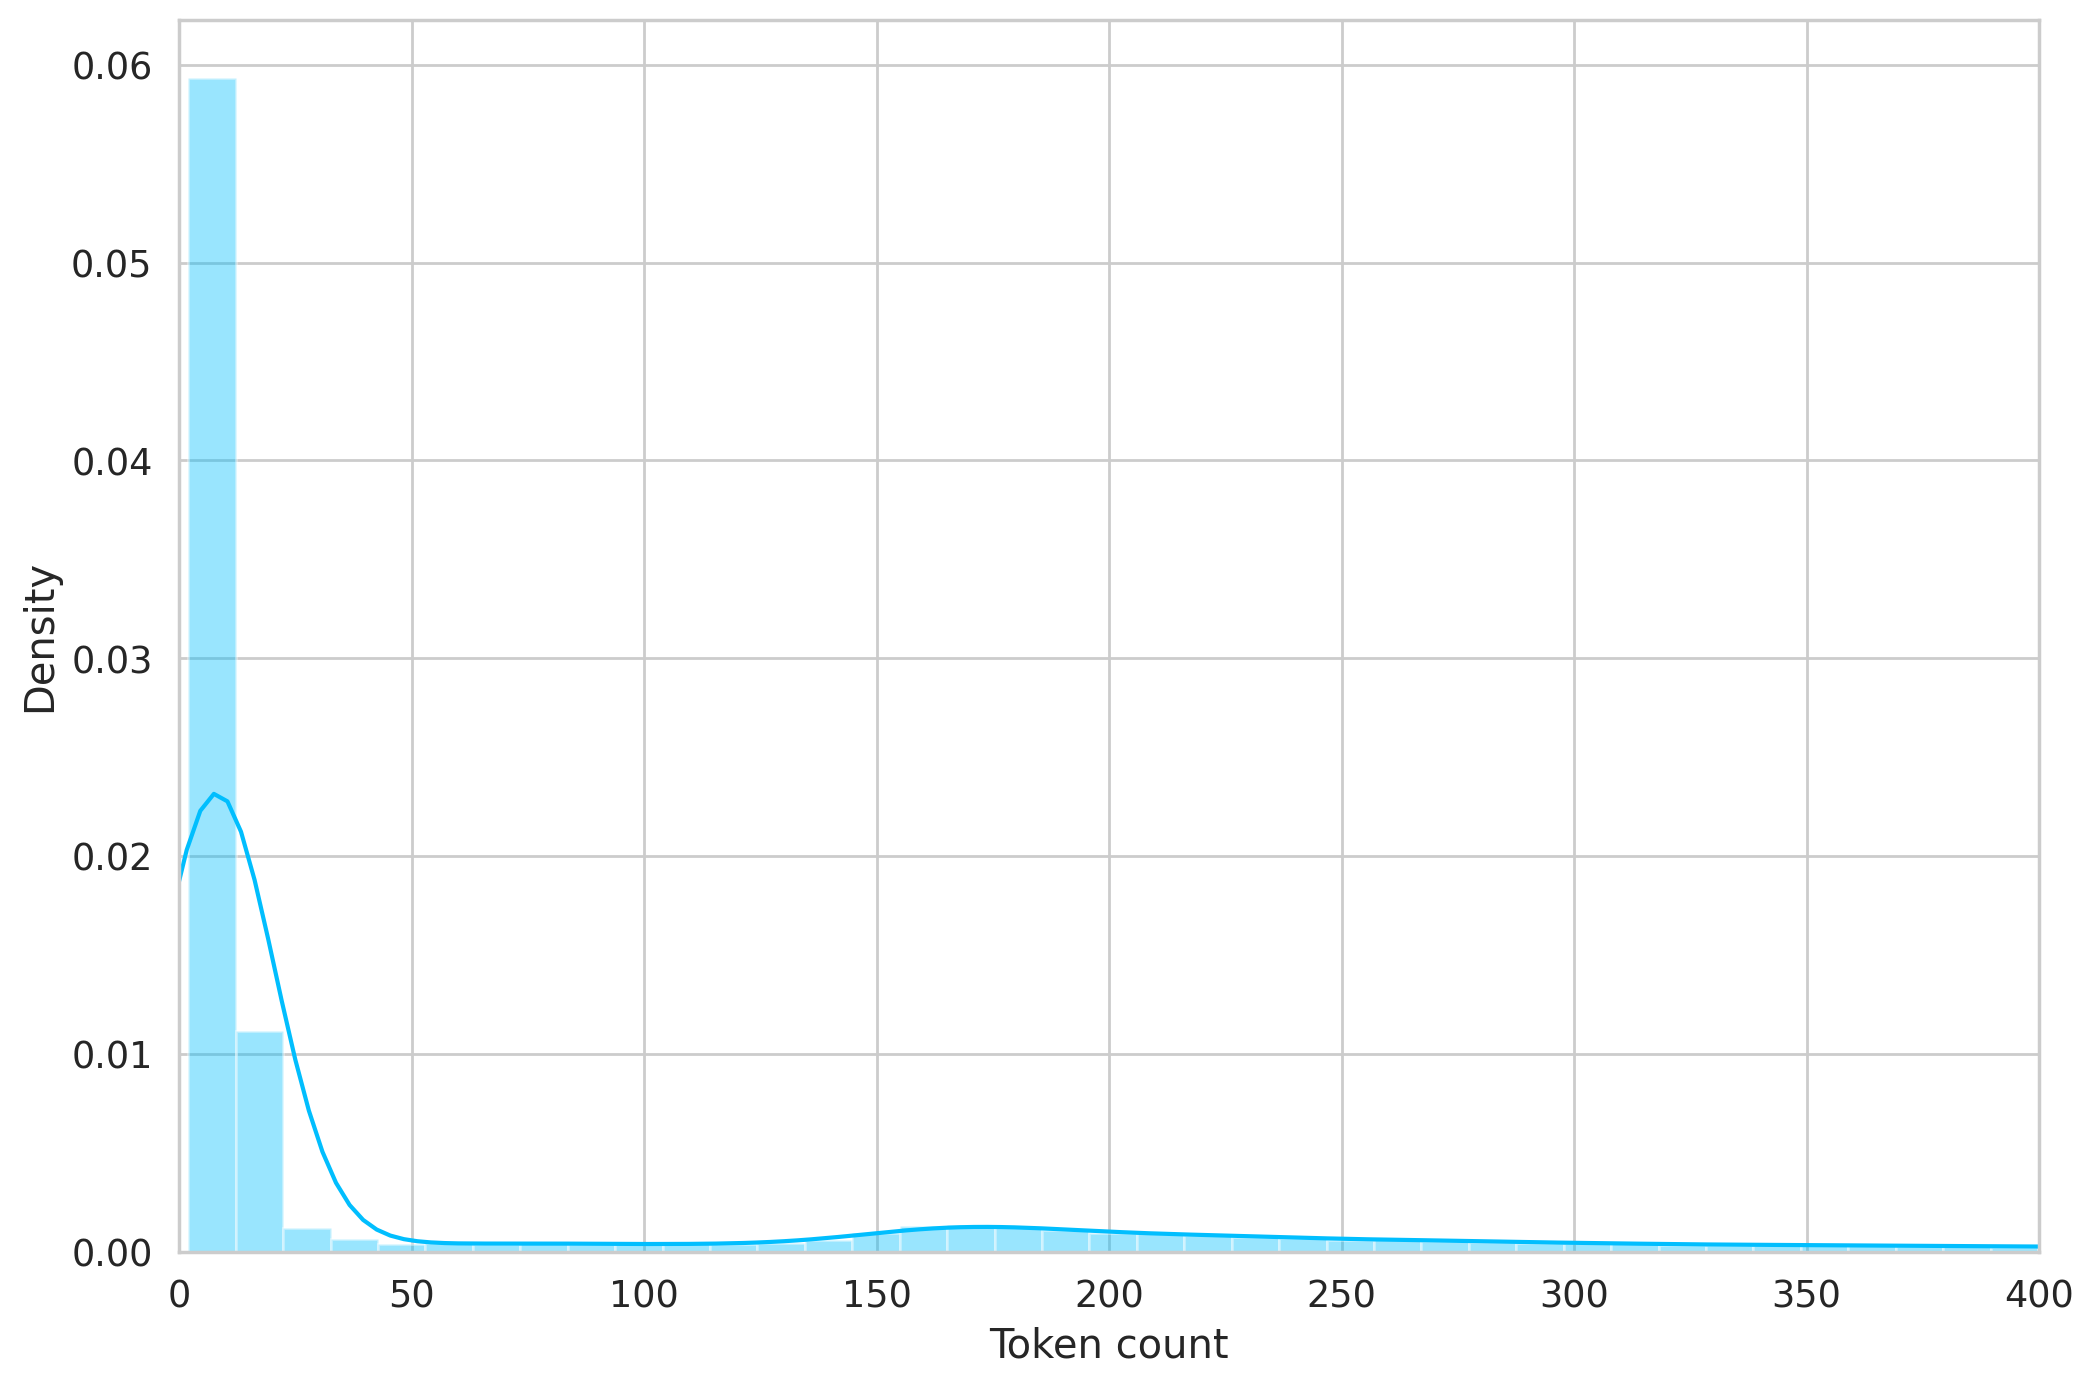

In [12]:
sns.distplot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count');

A maioria das sentenças tem menos de 50 tokens. É possível notar uma pequena elevação em torno de 150-200 tokens. Vamos selecionar as sentenças que tem no máximo 200. 

In [13]:
MAX_LEN = 50

In [14]:
class GPReviewDataset(Dataset):

	def __init__(self, reviews, targets, tokenizer, max_len):
		self.reviews = reviews
		self.targets = targets
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __len__(self):
		return len(self.reviews)

	def __getitem__(self, item):
		review = str(self.reviews[item])
		target = self.targets[item]

		encoding = self.tokenizer.encode_plus(
		review,
		add_special_tokens=True,
		max_length=self.max_len,
		return_token_type_ids=False,
		pad_to_max_length=True,
		return_attention_mask=True,
		return_tensors='pt',
		)

		return {
				'review_text': review,
				'input_ids': encoding['input_ids'].flatten(),
				'attention_mask': encoding['attention_mask'].flatten(),
				'targets': torch.tensor(target, dtype=torch.long)
				}

Separando os dados em treino, teste e validação

In [15]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED, stratify=df.Label)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test.Label)

In [16]:
df_train.shape, df_val.shape, df_test.shape

((162664, 3), (14353, 3), (14353, 3))

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
	ds = GPReviewDataset(
		reviews=df.Sentence.to_numpy(),
		targets=df.Label.to_numpy(),
		tokenizer=tokenizer,
		max_len=max_len
	)

	return DataLoader(
		ds,
		batch_size=batch_size,
		num_workers=4
	)

In [18]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
# Treinando o DataLoader

data = next(iter(train_data_loader))
data.keys()


/home/gui/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/gui/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the ma

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [20]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 50])
torch.Size([8, 50])
torch.Size([8])


## Classificação de Sentimentos com BERT e HuggingFace

In [21]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [22]:
last_hidden_state, pooled_output = bert_model(
	input_ids=encoding['input_ids'], 
	attention_mask=encoding['attention_mask']
).to_tuple()

In [23]:
last_hidden_state

tensor([[[ 0.1652, -0.4194,  0.6339,  ..., -0.0684,  0.1310, -0.1794],
         [ 0.3372, -0.0500,  0.1896,  ...,  0.1767, -0.3281, -0.4828],
         [ 0.7735, -0.4056,  0.2931,  ..., -0.0252, -0.3666, -0.5447],
         ...,
         [-0.0134, -0.1782,  0.5101,  ...,  0.1100, -0.2811, -0.4596],
         [-0.0622, -0.2804,  0.6265,  ...,  0.1553, -0.3318, -0.3384],
         [ 0.0097, -0.1667,  0.6331,  ...,  0.2275, -0.2980, -0.3583]]],
       grad_fn=<NativeLayerNormBackward0>)

In [24]:
pooled_output

tensor([[ 8.3006e-02,  3.8706e-02,  2.5846e-02,  1.0040e-01,  1.2745e-01,
          1.3410e-01,  9.9802e-01, -9.6787e-02,  3.3822e-02, -1.0499e-01,
         -8.8533e-01, -1.5965e-01,  2.8671e-02,  9.8608e-02, -6.8307e-02,
          3.8789e-02, -2.3805e-01,  3.7514e-02,  9.5964e-01,  9.4933e-01,
          1.4097e-01,  1.8291e-01,  1.3382e-01,  1.2682e-01,  8.9593e-02,
         -1.4468e-01,  8.5287e-02, -6.2916e-02,  1.0874e-01, -5.5734e-03,
         -6.8953e-02, -9.8062e-01, -9.0116e-01, -1.4604e-01,  1.6454e-02,
          1.4426e-02, -2.6772e-02, -8.3460e-02,  8.5891e-01,  7.9773e-02,
          3.6395e-02,  3.1375e-02, -9.1569e-01,  2.9664e-02,  1.3093e-01,
          2.8752e-02,  3.5198e-02,  1.2564e-01, -2.1054e-01,  3.7844e-02,
         -1.1321e-01,  1.3797e-02, -1.6091e-03, -6.3391e-02, -1.3050e-02,
          1.9411e-01, -7.2472e-03, -1.2902e-01,  6.6863e-02, -7.7037e-02,
         -4.8366e-02,  1.1210e-01,  3.2324e-02,  2.3864e-01,  2.1718e-03,
         -1.6899e-02, -7.4281e-02, -1.

In [25]:
class SentimentClassifier(nn.Module):

	def __init__(self, n_classes):
		super(SentimentClassifier, self).__init__()
		self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
		self.drop = nn.Dropout(p=0.3)
		self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

	def forward(self, input_ids, attention_mask):
		_, pooled_output = self.bert(
		input_ids=input_ids,
		attention_mask=attention_mask
		).to_tuple()
		output = self.drop(pooled_output)
		return self.out(output)

In [26]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [27]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 50])
torch.Size([8, 50])


In [28]:
print(input_ids)

tensor([[  101,  2471,   123,  3827,   202,  1247,   370,   123,  3827,   202,
          1247,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2533,   784,   555,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,   346, 16649,   222,  1151, 22283,   353,  2375,   298,  5708,
           346,   792,   222,  1151, 22283,   353,  2375,   298,  5708,   102,
             0,     0,     0,     0,     0,     0,

In [29]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3125, 0.4549, 0.2326],
        [0.3047, 0.4406, 0.2547],
        [0.3342, 0.4486, 0.2172],
        [0.3521, 0.4586, 0.1893],
        [0.2755, 0.5162, 0.2083],
        [0.2845, 0.2455, 0.4700],
        [0.3340, 0.4307, 0.2353],
        [0.2769, 0.4933, 0.2298]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Treinamento

In [30]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
											optimizer,
											num_warmup_steps=0,
											num_training_steps=total_steps
											)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/gui/.local/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
	model = model.train()

	losses = []
	correct_predictions = 0
	
	for d in data_loader:
		input_ids = d["input_ids"].to(device)
		attention_mask = d["attention_mask"].to(device)
		targets = d["targets"].to(device)

		outputs = model(
		input_ids=input_ids,
		attention_mask=attention_mask
		)

		_, preds = torch.max(outputs, dim=1)
		loss = loss_fn(outputs, targets)

		correct_predictions += torch.sum(preds == targets)
		losses.append(loss.item())

		loss.backward()
		nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
		optimizer.step()
		scheduler.step()
		optimizer.zero_grad()

	return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
	model = model.eval()

	losses = []
	correct_predictions = 0

	with torch.no_grad():
		for d in data_loader:
			input_ids = d["input_ids"].to(device)
			attention_mask = d["attention_mask"].to(device)
			targets = d["targets"].to(device)

			outputs = model(
				input_ids=input_ids,
				attention_mask=attention_mask
			).to_tuple()
			_, preds = torch.max(outputs, dim=1)

			loss = loss_fn(outputs, targets)

			correct_predictions += torch.sum(preds == targets)
			losses.append(loss.item())

	return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

	print(f'Epoch {epoch + 1}/{EPOCHS}')
	print('-' * 10)

	train_acc, train_loss = train_epoch(
		model,
		train_data_loader,    
		loss_fn, 
		optimizer, 
		device, 
		scheduler, 
		len(df_train)
	)

	print(f'Train loss {train_loss} accuracy {train_acc}')

	val_acc, val_loss = eval_model(
		model,
		val_data_loader,
		loss_fn, 
		device, 
		len(df_val)
	)

	print(f'Val   loss {val_loss} accuracy {val_acc}')
	print()

	history['train_acc'].append(train_acc)
	history['train_loss'].append(train_loss)
	history['val_acc'].append(val_acc)
	history['val_loss'].append(val_loss)

	if val_acc > best_accuracy:
		torch.save(model.state_dict(), 'best_model_state7')
		torch.save(model.state_dict(), 'best_model_state7.pth')
		best_accuracy = val_acc

Epoch 1/5
----------


/home/gui/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/gui/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the ma

KeyboardInterrupt: 

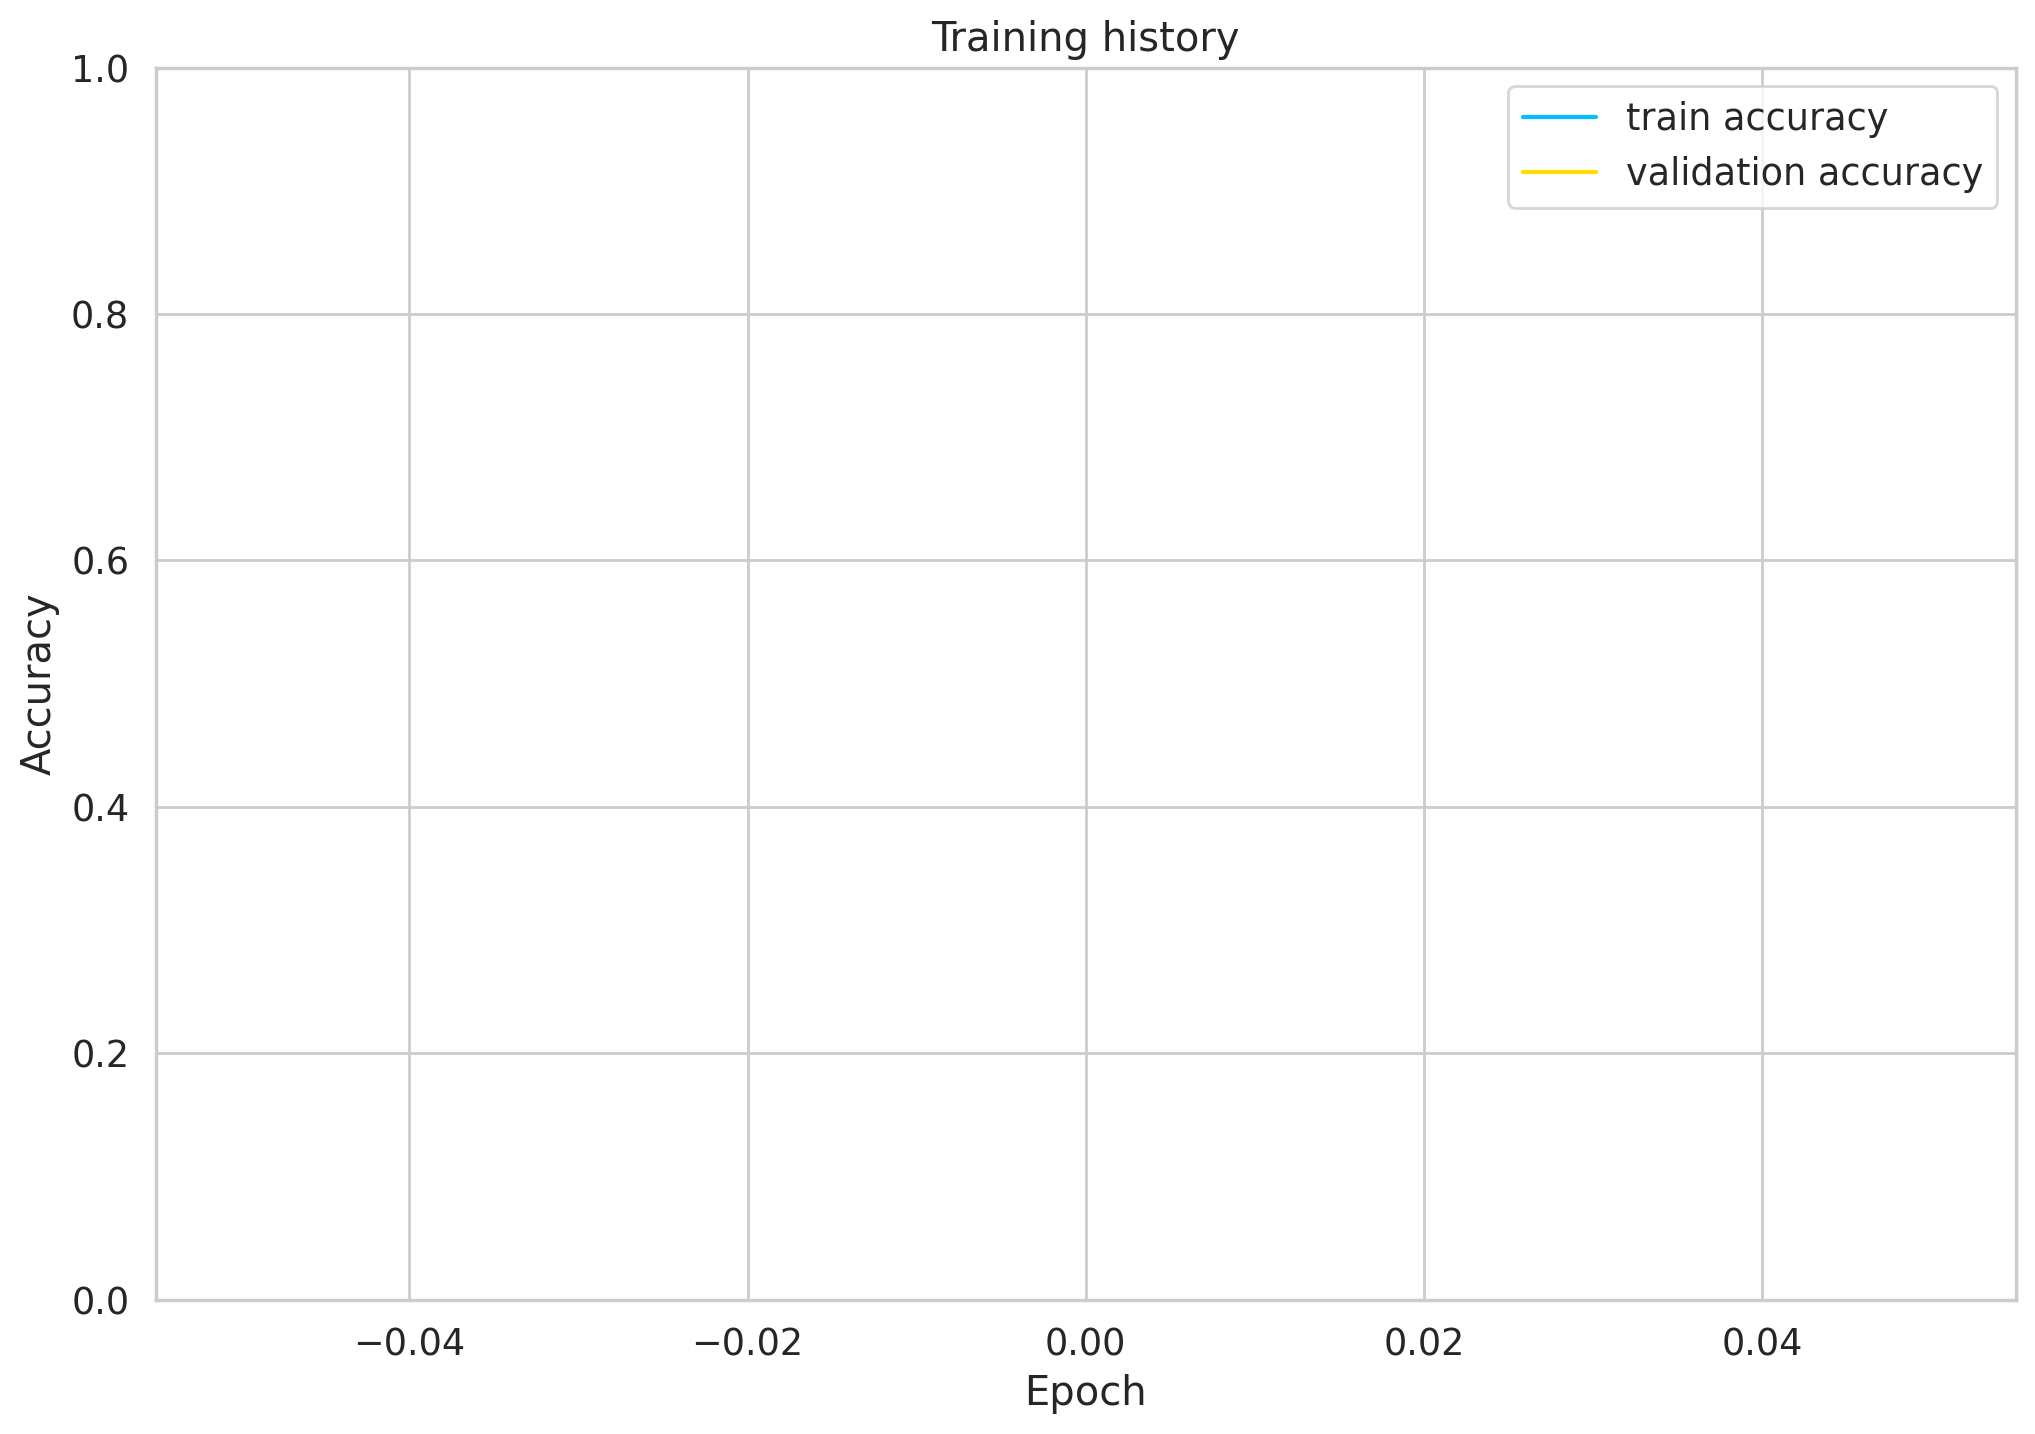

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

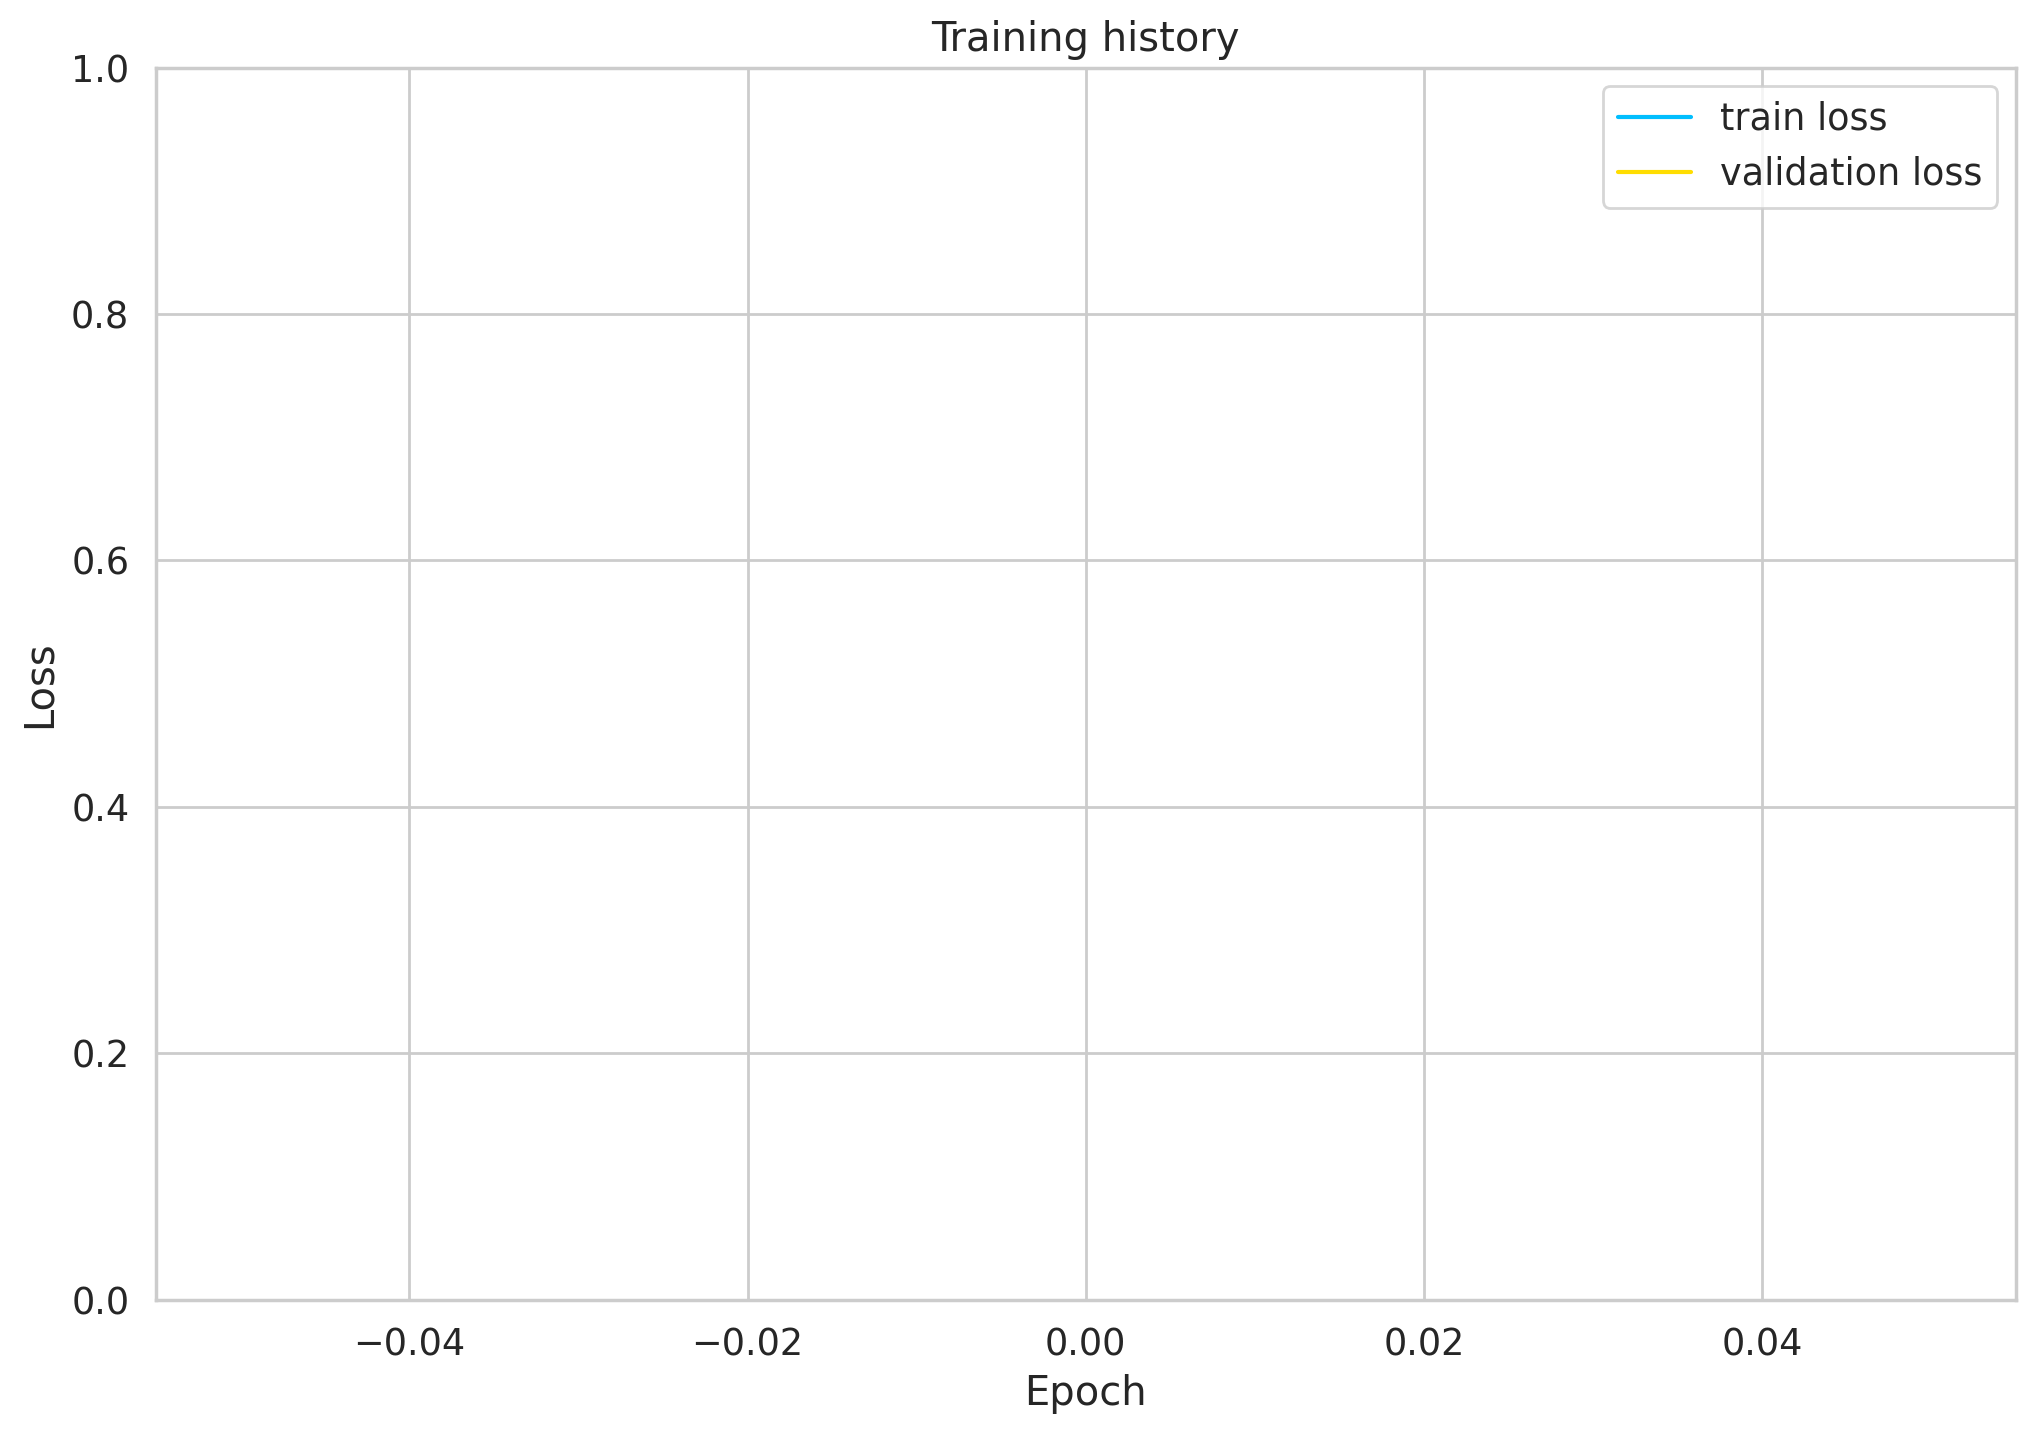

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

In [ ]:
test_acc, _ = eval_model(
	model,
	test_data_loader,
	loss_fn,
	device,
	len(df_test)
)

test_acc.item()


/home/gui/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/gui/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the ma

AttributeError: 'Tensor' object has no attribute 'to_tuple'

In [ ]:
def get_predictions(model, data_loader):
	model = model.eval()
	
	review_texts = []
	predictions = []
	prediction_probs = []
	real_values = []

	with torch.no_grad():
		for d in data_loader:

			texts = d["review_text"]
			input_ids = d["input_ids"].to(device)
			attention_mask = d["attention_mask"].to(device)
			targets = d["targets"].to(device)

			outputs = model(
				input_ids=input_ids,
				attention_mask=attention_mask
			)
			_, preds = torch.max(outputs, dim=1)

			probs = F.softmax(outputs, dim=1)

			review_texts.extend(texts)
			predictions.extend(preds)
			prediction_probs.extend(probs)
			real_values.extend(targets)

	predictions = torch.stack(predictions).cpu()
	prediction_probs = torch.stack(prediction_probs).cpu()
	real_values = torch.stack(real_values).cpu()
	return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
																model,
																test_data_loader
																)

NameError: name 'get_predictions' is not defined

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
	hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
	hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
	hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
	plt.ylabel('True sentiment')
	plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
						'class_names': class_names,
						'values': y_pred_probs[idx]
					})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);